# Gastrointestinal disease Detection and classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import tensorflow as tf
tf.config.list_physical_devices(
    device_type=None
)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Rescaling

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")



In [19]:
# Removed deprecated TensorFlow logging settings
dataset_path = "/content/drive/MyDrive/Dataset/unsplit-dataset"

image_size = (224, 224)
batch_size = 64
# Load datasets
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size)

class_names = train_ds.class_names


normalization_layer = Rescaling(1./255)

# Apply normalization to datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 8000 files belonging to 8 classes.
Using 4800 files for training.
Found 8000 files belonging to 8 classes.
Using 3200 files for validation.


In [20]:
# Split validation dataset into validation and test sets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [21]:
# Optimize dataset loading with prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))


In [23]:
# Build the model
model = Sequential()
base_model = tf.keras.applications.ResNet101V2(
    include_top=False,
    weights="imagenet",
    pooling='max',
    classifier_activation="softmax",  # Changed to None for logits output
)

In [24]:
# Set base model to trainable
for layer in base_model.layers:
        layer.trainable=True

model.add(base_model)
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

In [25]:
# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [26]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 2048)                │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │          16,392 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,642,952 (162.67 MB)

 Trainable params: 42,545,288 (162.30 MB)

 Non-trainable params: 97,664 (381.50 KB)

In [27]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
best = ModelCheckpoint(filepath="/content/drive/MyDrive/Dataset/best/model_best_val_accuracy.weights.h5",
                        save_weights_only=True, monitor="val_accuracy", mode="max", save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [28]:
# Train the model
history = model.fit(train_ds, epochs=70, validation_data=val_ds, callbacks=[reduce_lr, best])

# Save the model
model.save("finalwithhighaccuracy10ep.h5")

Epoch 1/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 1210s 14s/step - accuracy: 0.5097 - loss: 3.3247 - precision: 0.5303 - recall: 0.4689 - val_accuracy: 0.2425 - val_loss: 16.9901 - val_precision: 0.2464 - val_recall: 0.2150 - learning_rate: 0.0010
Epoch 2/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.7357 - loss: 0.6805 - precision: 0.7587 - recall: 0.6945 - val_accuracy: 0.6175 - val_loss: 1.4960 - val_precision: 0.6294 - val_recall: 0.6094 - learning_rate: 0.0010
Epoch 3/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.8072 - loss: 0.5112 - precision: 0.8260 - recall: 0.7908 - val_accuracy: 0.7231 - val_loss: 1.4002 - val_precision: 0.7270 - val_recall: 0.7156 - learning_rate: 0.0010
Epoch 4/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.8196 - loss: 0.4546 - precision: 0.8292 - recall: 0.8101 - val_accuracy: 0.8219 - val_loss: 0.5549 - val_precision: 0.8325 - val_recall: 0.8106 - learning_rate: 0.0010
Epoch 5/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.

In [29]:

# Extract training history
metrics = history.history
loss = metrics['loss']
val_loss = metrics['val_loss']
accuracy = metrics['accuracy']
val_accuracy = metrics['val_accuracy']
precision = metrics['precision']
val_precision = metrics['val_precision']
recall = metrics['recall']
val_recall = metrics['val_recall']
print(history.history)

{'accuracy': [0.5958333611488342, 0.768750011920929, 0.815833330154419, 0.8270833492279053, 0.8600000143051147, 0.85916668176651, 0.871666669845581, 0.8727083206176758, 0.887499988079071, 0.8866666555404663, 0.887291669845581, 0.8868749737739563, 0.8941666483879089, 0.8941666483879089, 0.9043750166893005, 0.8835416436195374, 0.8708333373069763, 0.8652083277702332, 0.9131249785423279, 0.918541669845581, 0.9316666722297668, 0.9366666674613953, 0.9366666674613953, 0.9422916769981384, 0.9449999928474426, 0.9449999928474426, 0.9522916674613953, 0.9537500143051147, 0.9577083587646484, 0.9606249928474426, 0.9574999809265137, 0.9602083563804626, 0.9639583230018616, 0.9618750214576721, 0.9618750214576721, 0.9616666436195374, 0.9645833373069763, 0.9662500023841858, 0.9614583253860474, 0.9670833349227905, 0.9616666436195374, 0.9662500023841858, 0.9649999737739563, 0.9643750190734863, 0.9649999737739563, 0.9674999713897705, 0.9660416841506958, 0.965624988079071, 0.9674999713897705, 0.9685416817665

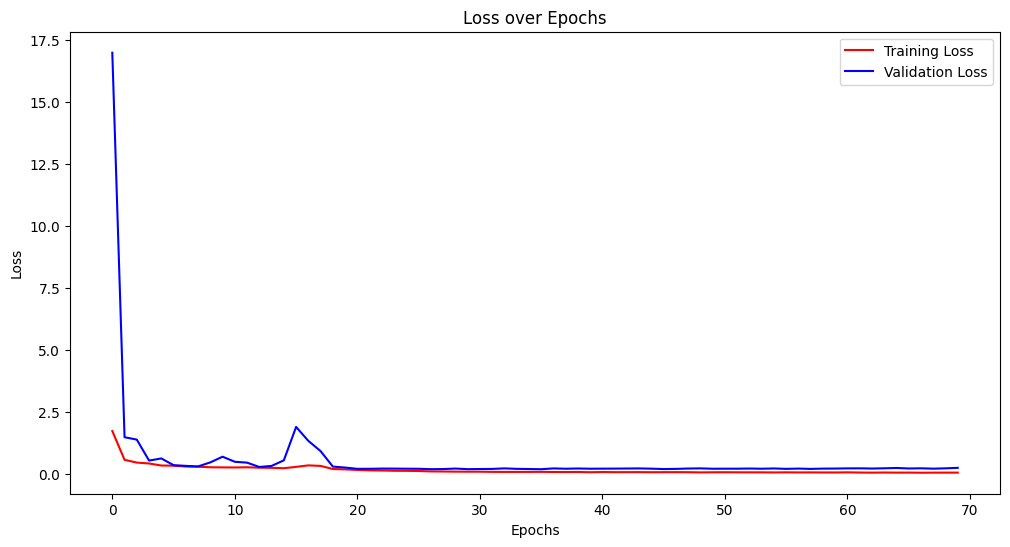

In [30]:
# Calculate F1 scores
f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]
val_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




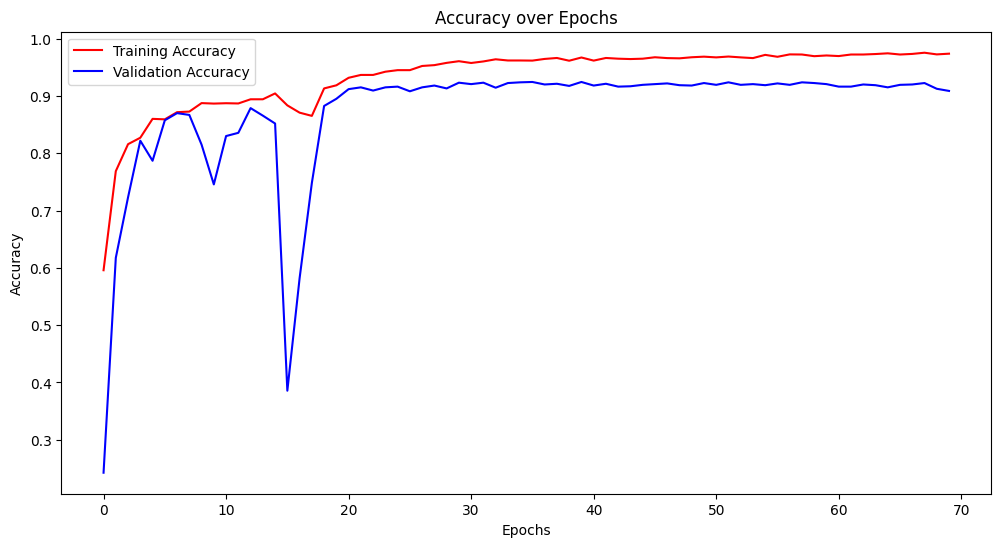

In [31]:
# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



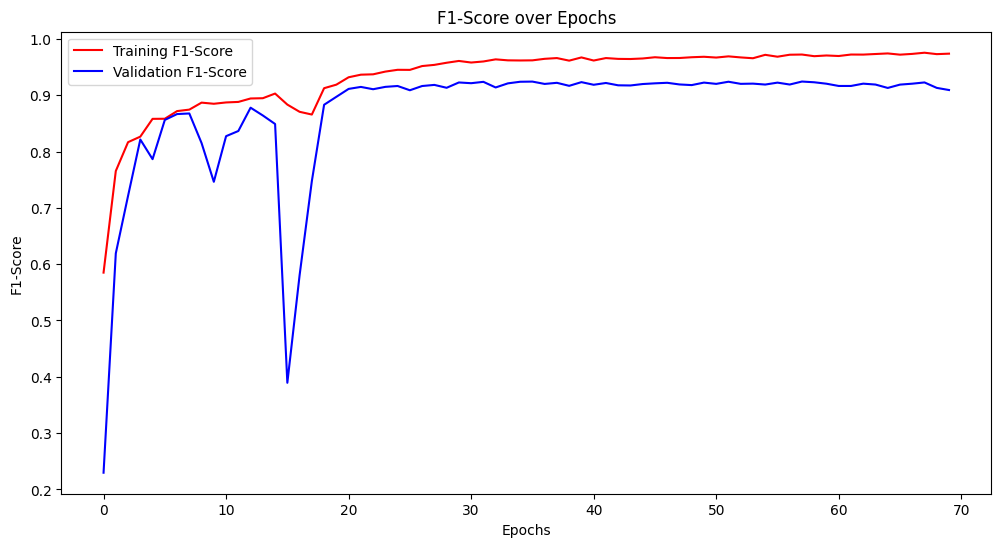

In [32]:
# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(f1, label='Training F1-Score', color='red')
plt.plot(val_f1, label='Validation F1-Score', color='blue')
plt.title('F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [33]:
# Evaluate on test data
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Test Accuracy: 0.90


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Test Accuracy: 0.90
Image 

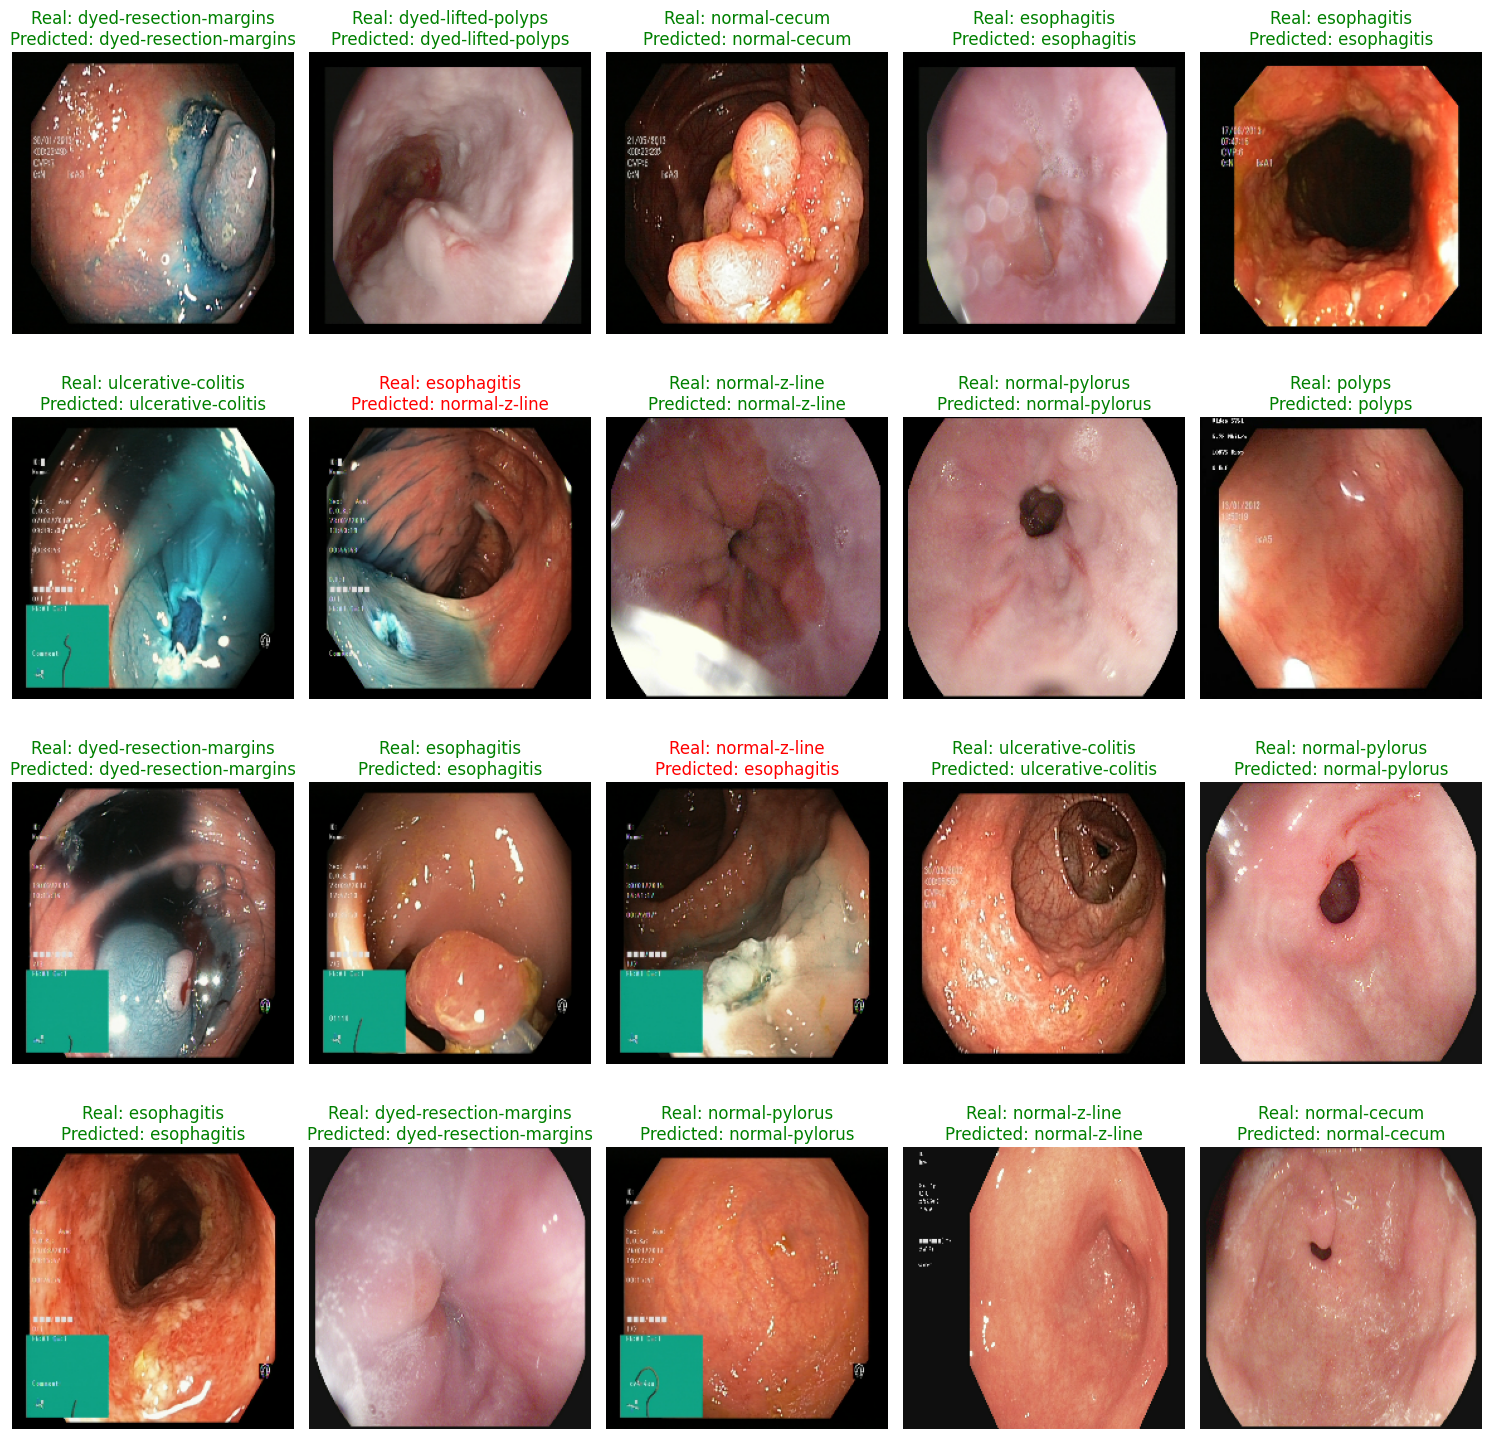

In [34]:
# Evaluate on test data
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.2f}")

import random
import os

# Convert test_ds to a list of images and labels
class_names = sorted(os.listdir(dataset_path))  # List of class directories

# Convert test_ds to a list of images and labels
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Select 20 random indices from the test dataset
num_images_to_display = 20
random_indices = random.sample(range(len(true_labels)), num_images_to_display)

# Display the real and predicted labels for the selected images
plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    # Debug: Print pixel value range and shape
    print(f"Image {idx} pixel range: {test_images[idx].min()} to {test_images[idx].max()}")
    print(f"Image {idx} shape: {test_images[idx].shape}")

    # Denormalize the image if necessary
    image_to_display = test_images[idx]
    if image_to_display.max() <= 1:  # Normalized to [0, 1]
        image_to_display = (image_to_display * 255).astype("uint8")
    elif image_to_display.min() < 0:  # Normalized to [-1, 1]
        image_to_display = ((image_to_display + 1) * 127.5).astype("uint8")

    # Display the image
    plt.subplot(4, 5, i + 1)
    plt.imshow(image_to_display.astype("uint8"))

    # Get real and predicted class names
    real_class = class_names[true_labels[idx]]
    predicted_class = class_names[predicted_labels[idx]]

    # Set title color based on prediction accuracy
    title_color = 'green' if true_labels[idx] == predicted_labels[idx] else 'red'
    plt.title(f"Real: {real_class}\nPredicted: {predicted_class}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()


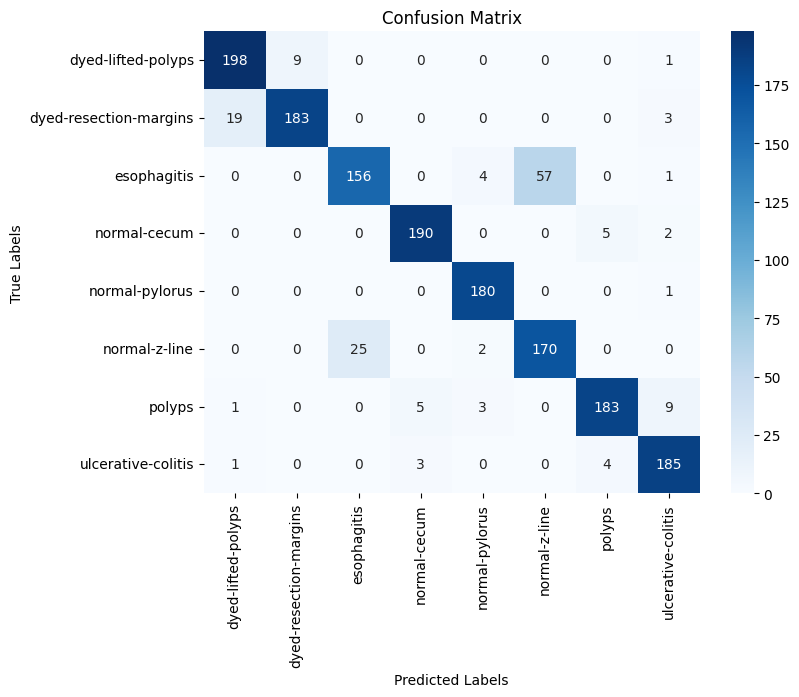


Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.90      0.95      0.93       208
dyed-resection-margins       0.95      0.89      0.92       205
           esophagitis       0.86      0.72      0.78       218
          normal-cecum       0.96      0.96      0.96       197
        normal-pylorus       0.95      0.99      0.97       181
         normal-z-line       0.75      0.86      0.80       197
                polyps       0.95      0.91      0.93       201
    ulcerative-colitis       0.92      0.96      0.94       193

              accuracy                           0.90      1600
             macro avg       0.91      0.91      0.90      1600
          weighted avg       0.91      0.90      0.90      1600



In [35]:

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Softmax Probabilities for 8 Classes:
dyed-lifted-polyps: 0.1029
dyed-resection-margins: 0.1029
esophagitis: 0.2794
normal-cecum: 0.1029
normal-pylorus: 0.1029
normal-z-line: 0.1031
polyps: 0.1029
ulcerative-colitis: 0.1029
Predicted Class: esophagitis


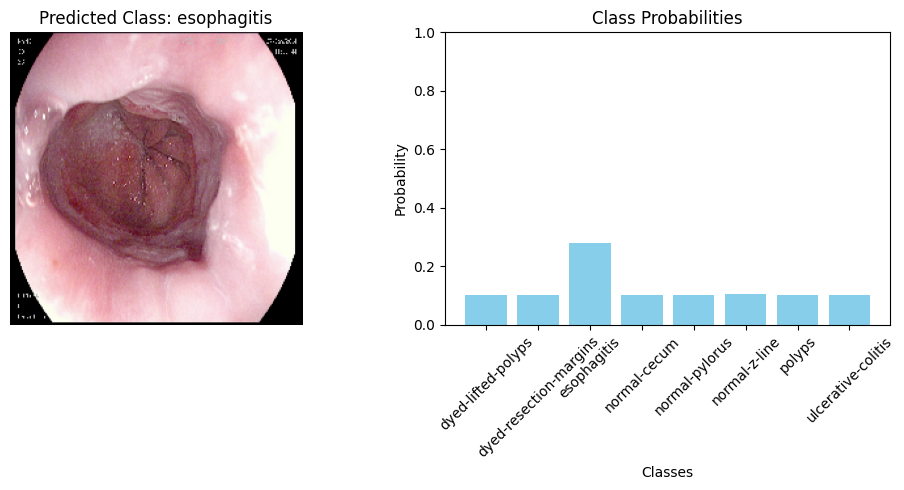

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(224, 224)):
    # Load and resize the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    # Convert the image to an array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Normalize to [0, 1]
    img_array = img_array / 255.0
    # Expand dimensions to match the model input shape
    return np.expand_dims(img_array, axis=0)

# Test image path (replace with an actual image path from your dataset)
test_image_path = '/content/drive/MyDrive/Dataset/unsplit-dataset/esophagitis/00687a70-bbad-4bf9-864f-9f7b3c27a2c8.jpg'  # Example

# Preprocess the test image
test_image = preprocess_image(test_image_path)

# Predict logits from the model
logits = model.predict(test_image)

# Apply Softmax to get probabilities
softmax_values = tf.nn.softmax(logits[0]).numpy()

# Display class probabilities
print("Softmax Probabilities for 8 Classes:")
for class_name, prob in zip(class_names, softmax_values):
    print(f"{class_name}: {prob:.4f}")

# Get the predicted class
predicted_class = class_names[np.argmax(softmax_values)]
print(f"Predicted Class: {predicted_class}")

# Plot the image and the softmax probabilities
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(test_image[0])  # Display the image after removing the batch dimension
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')

# Display the softmax probabilities as a bar graph
plt.subplot(1, 2, 2)
plt.bar(class_names, softmax_values, color='skyblue')
plt.title('Class Probabilities')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]

# Show the plot
plt.tight_layout()
plt.show()


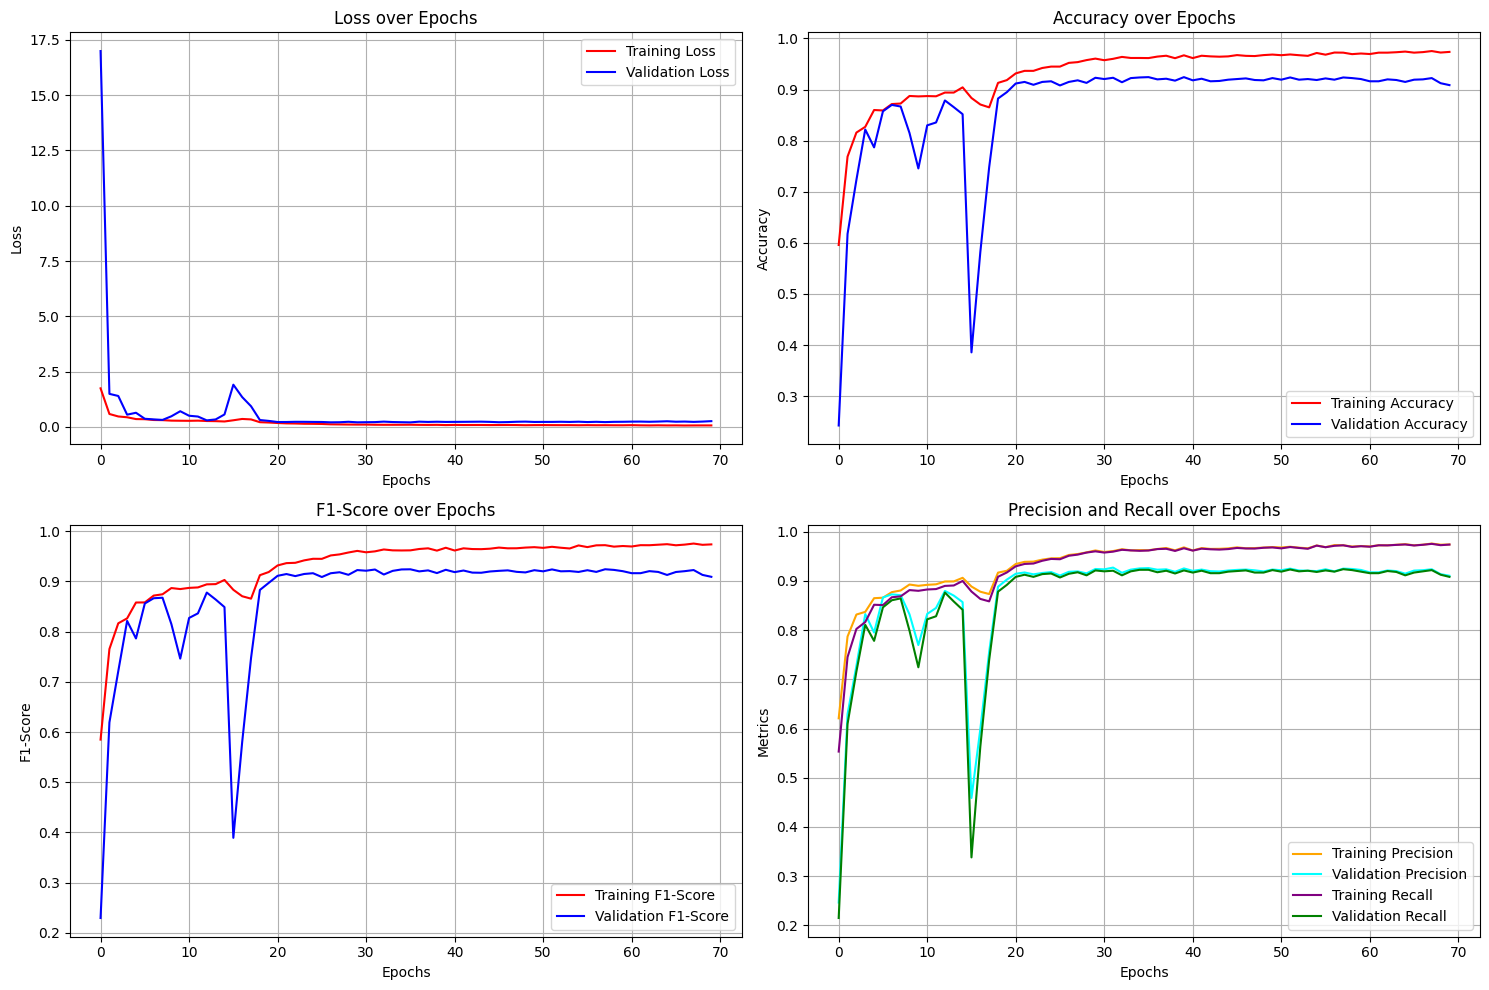

In [37]:
# Overall analysis

# Extract metrics from the training history
metrics = history.history

# Training and validation metrics
loss = metrics['loss']
val_loss = metrics['val_loss']
accuracy = metrics['accuracy']
val_accuracy = metrics['val_accuracy']
precision = metrics['precision']
val_precision = metrics['val_precision']
recall = metrics['recall']
val_recall = metrics['val_recall']

# Calculate F1-Score for Training and Validation
f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]
val_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

# Create a figure for overall performance
plt.figure(figsize=(15, 10))

# Subplot 1: Loss
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Subplot 2: Accuracy
plt.subplot(2, 2, 2)
plt.plot(accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Subplot 3: F1-Score
plt.subplot(2, 2, 3)
plt.plot(f1, label='Training F1-Score', color='red')
plt.plot(val_f1, label='Validation F1-Score', color='blue')
plt.title('F1-Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.grid()

# Subplot 4: Precision and Recall
plt.subplot(2, 2, 4)
plt.plot(precision, label='Training Precision', color='orange')
plt.plot(val_precision, label='Validation Precision', color='cyan')
plt.plot(recall, label='Training Recall', color='purple')
plt.plot(val_recall, label='Validation Recall', color='green')
plt.title('Precision and Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid()

# Adjust layout
plt.tight_layout()
plt.show()
